In [4]:
import os
import json
import pandas as pd
from pathlib import Path
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt


# Base directory where all experiment results are stored
base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")

# Mapping of directory names to methodology names
methodology_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM",
    "multi_run_2025-05-10_14-26-00": "Baseline",
    "multi_run_2025-05-10_18-05-54": "CP",
    "multi_run_2025-05-11_00-21-16": "CoT",
}

# Find all multi-run directories
multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

# To store results from all experiments
all_data = []

# Process each multi-run directory
for multi_run_dir in multi_run_dirs:
    multi_run_name = multi_run_dir.name
    methodology = methodology_mapping.get(multi_run_name, multi_run_name)
    print(f"\nProcessing multi-run: {multi_run_name} (Methodology: {methodology})")
    
    # Find all run directories (run_1, run_2, etc.)
    run_dirs = [d for d in multi_run_dir.glob("run_*") if d.is_dir()]
    print(f"Found {len(run_dirs)} run directories")
    
    for run_dir in run_dirs:
        run_name = run_dir.name
        
        # Find evaluation directories
        eval_dirs = [d for d in run_dir.glob("ev_*") if d.is_dir()]
        
        if not eval_dirs:
            print(f"  × No evaluation directory found in {run_name}")
            continue
            
        # Process each evaluation directory
        for eval_dir in eval_dirs:
            eval_timestamp = eval_dir.name.replace("ev_", "")
            eval_dataset_file = eval_dir / "evaluation_dataset.json"
            
            if not eval_dataset_file.exists():
                print(f"  × Evaluation dataset file not found in {eval_dir.name}")
                continue
                
            print(f"  • Processing {run_name}/{eval_dir.name}")
            
            try:
                # Load the evaluation dataset
                with open(eval_dataset_file, 'r') as f:
                    eval_data = json.load(f)
                
                # For each item in the evaluation dataset, add metadata
                for item in eval_data:
                    item["methodology"] = methodology
                    item["multi_run_dir"] = multi_run_name
                    item["eval_dir"] = eval_dir.name
                    all_data.append(item)
                    
                print(f"    ✓ Added {len(eval_data)} items from dataset")
                
            except Exception as e:
                print(f"  × Error processing {eval_dataset_file}: {e}")


df = pd.DataFrame(all_data)
    

Found 7 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-25_17-14-57', 'multi_run_2025-05-02_00-31-21']

Processing multi-run: multi_run_2025-05-11_00-21-16 (Methodology: CoT)
Found 10 run directories
  • Processing run_2/ev_2025-05-18_22-56-33
    ✓ Added 32 items from dataset
  • Processing run_5/ev_2025-05-11_02-25-26
    ✓ Added 32 items from dataset
  • Processing run_4/ev_2025-05-11_01-22-23
    ✓ Added 32 items from dataset
  • Processing run_3/ev_2025-05-11_00-57-28
    ✓ Added 32 items from dataset
  • Processing run_10/ev_2025-05-12_04-07-17
    ✓ Added 32 items from dataset
  • Processing run_6/ev_2025-05-12_02-40-23
    ✓ Added 32 items from dataset
  • Processing run_1/ev_2025-05-12_00-25-08
    ✓ Added 32 items from dataset
  • Processing run_8/ev_2025-05-11_09-54-17
    ✓ Added 32 items from dataset
  • Processing 

### The following plots show the mean distribution of prompt and completion tokens for each methodology.

In [5]:
# This code block is used to calculate the mean distribution of tokens for each methodology


# Start with a copy of the original dataframe
df_tokens = df.copy()

# For standard methodologies, filter out rows with NaN values
std_data = df_tokens[df_tokens['methodology'] != 'LtM'].dropna(
    subset=['sparql_query_construction_prompt_tokens', 'sparql_query_construction_completion_tokens']
)

# For LtM methodology, filter out rows with NaN in component columns
ltm_data = df_tokens[df_tokens['methodology'] == 'LtM'].dropna(
    subset=[
        'planning_prompt_tokens', 'planning_completion_tokens',
        'pattern_prompt_tokens', 'pattern_completion_tokens',
        'assembler_prompt_tokens', 'assembler_completion_tokens'
    ]
)

# For LtM, calculate the sum of component tokens
ltm_data['sparql_query_construction_prompt_tokens'] = (
    ltm_data[['planning_prompt_tokens', 'pattern_prompt_tokens', 'assembler_prompt_tokens']]
    .sum(axis=1)
)

ltm_data['sparql_query_construction_completion_tokens'] = (
    ltm_data[['planning_completion_tokens', 'pattern_completion_tokens', 'assembler_completion_tokens']]
    .sum(axis=1)
)

# Combine the filtered dataframes
df_tokens_clean = pd.concat([std_data, ltm_data])

# Calculate mean values for each methodology
token_means = df_tokens_clean.groupby('methodology').agg({
    'sparql_query_construction_prompt_tokens': 'mean',
    'sparql_query_construction_completion_tokens': 'mean'
}).reset_index()

Token usage by methodology:
    methodology  sparql_query_construction_prompt_tokens  \
0      Baseline                              1849.949367   
1           CoT                              2333.010417   
2            CP                              2347.884375   
3          CP-A                              5766.643750   
4  few-shot CoT                             15968.134752   
5           LtM                             24301.404389   

   sparql_query_construction_completion_tokens  total_tokens  
0                                   120.465190   1970.414557  
1                                   319.104167   2652.114583  
2                                   243.915625   2591.800000  
3                                   167.271875   5933.915625  
4                                   820.184397  16788.319149  
5                                   709.583072  25010.987461  


<Figure size 800x600 with 0 Axes>

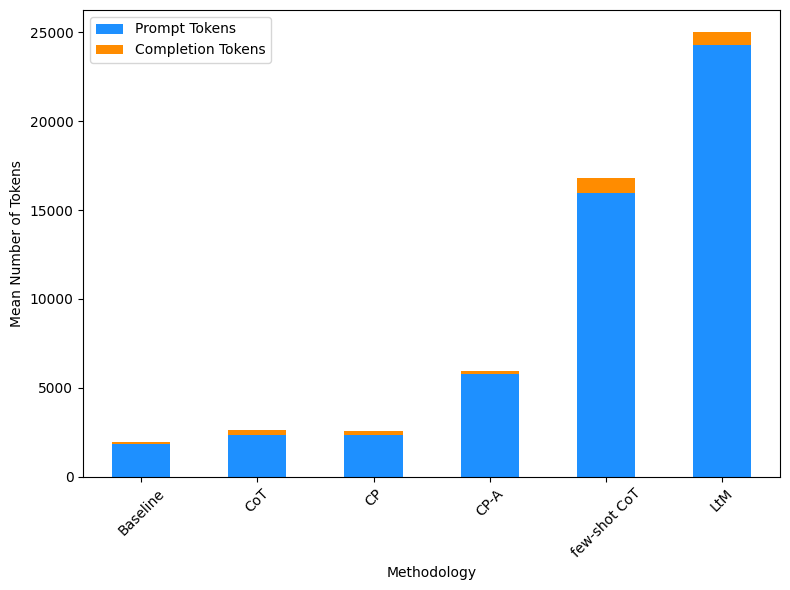

In [6]:
# Create the plot
plt.figure(figsize=(8, 6))
methodology_order = ["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]
token_means = token_means.set_index('methodology').reindex(methodology_order).reset_index()

# Add a column for total tokens
token_means['total_tokens'] = token_means['sparql_query_construction_prompt_tokens'] + token_means['sparql_query_construction_completion_tokens']

# Print the token counts for verification
print("Token usage by methodology:")
print(token_means[['methodology', 'sparql_query_construction_prompt_tokens', 
                  'sparql_query_construction_completion_tokens', 'total_tokens']])

# Create a stacked bar chart
ax = token_means.plot(
    x='methodology',
    y=['sparql_query_construction_prompt_tokens', 'sparql_query_construction_completion_tokens'],
    kind='bar',
    stacked=True,
    color=['dodgerblue', 'darkorange'],
    figsize=(8, 6)
)


#plt.title('Average Token Usage by Methodology', fontsize=14)
plt.xlabel('Methodology')
plt.ylabel('Mean Number of Tokens')
plt.legend(['Prompt Tokens', 'Completion Tokens'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/prompt_completion_token_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
latex_table = token_means[['methodology', 'sparql_query_construction_prompt_tokens', 
                          'sparql_query_construction_completion_tokens', 'total_tokens']].to_latex(
    index=False,
    caption="Token Usage by Methodology",
    label="tab:token-usage",
    column_format="lrrr",
    formatters={
        'sparql_query_construction_prompt_tokens': lambda x: f"{x:,.1f}",
        'sparql_query_construction_completion_tokens': lambda x: f"{x:,.1f}",
        'total_tokens': lambda x: f"{x:,.1f}"
    },
    header=['Methodology', 'Prompt Tokens', 'Completion Tokens', 'Total Tokens']
)

print(latex_table)

with open('./multi_experimental_run_plots/token_usage_table.tex', 'w') as f:
    f.write(latex_table)

\begin{table}
\caption{Token Usage by Methodology}
\label{tab:token-usage}
\begin{tabular}{lrrr}
\toprule
Methodology & Prompt Tokens & Completion Tokens & Total Tokens \\
\midrule
Baseline & 1,849.9 & 120.5 & 1,970.4 \\
CoT & 2,333.0 & 319.1 & 2,652.1 \\
CP & 2,347.9 & 243.9 & 2,591.8 \\
CP-A & 5,766.6 & 167.3 & 5,933.9 \\
few-shot CoT & 15,968.1 & 820.2 & 16,788.3 \\
LtM & 24,301.4 & 709.6 & 25,011.0 \\
\bottomrule
\end{tabular}
\end{table}



## This section is part of the Execution-based Evaluation.

### This plot shows the rate of syntactically valid SPARQL queries by methodology.

In [8]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
# costum map for dodgerblue
dark_blue = '#104E8B'  
dodgerblue = '#1E90FF'
n_colors = 6
cmap = LinearSegmentedColormap.from_list("", [dark_blue, dodgerblue])
dodgerblue_palette = [cmap(x) for x in np.linspace(0.2, 1.0, n_colors)]
#dodgerblue_palette = sns.color_palette("dark:#1E90FF", as_cmap=False)
#dodgerblue_palette = sns.color_palette("light:#1E90FF", as_cmap=False)
plt.figure(figsize=(6, 6))
ax = sns.barplot(x="methodology", y="syntactically_valid", data=valid_summary, palette=dodgerblue_palette,legend=False)
plt.ylabel("Mean rate (%)")
plt.xlabel("Methodology")
plt.xticks(rotation=45, ha='right', fontsize=10)

for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )
plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/syntactically_valid_percentage.png", dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'valid_summary' is not defined

<Figure size 600x600 with 0 Axes>

### The following plot shows the rate of empty results of syntactically valid SPARQL queries by methodology.

In [ ]:
df_error = df[df["is_valid_sparql"] == True]

total_passed_queries_to_endpoint = (
    df_error
    .groupby("methodology")
    .size() 
    .reset_index(name="total_passed_queries_to_endpoint")
)

empty_result_counts = (
    df_error[df_error["error_occured_at_endpoint_message"] == "no error, but empty result"]
    .groupby("methodology")
    .size()
    .reset_index(name="empty_result_count")
)

summary = pd.merge(total_passed_queries_to_endpoint, empty_result_counts, on="methodology", how="left")
summary["empty_result_count"] = summary["empty_result_count"].fillna(0)
summary["percentage_empty_result"] = summary["empty_result_count"] / summary["total_passed_queries_to_endpoint"] * 100

print(summary.head(6))

    methodology  total_passed_queries_to_endpoint  empty_result_count  \
0      Baseline                                22                 0.0   
1            CP                               199               136.0   
2          CP-A                               285                97.0   
3           CoT                               229               156.0   
4           LtM                               308                77.0   
5  few-shot CoT                               209               120.0   

   percentage_empty_result  
0                 0.000000  
1                68.341709  
2                34.035088  
3                68.122271  
4                25.000000  
5                57.416268  


/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_45558/1354079890.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


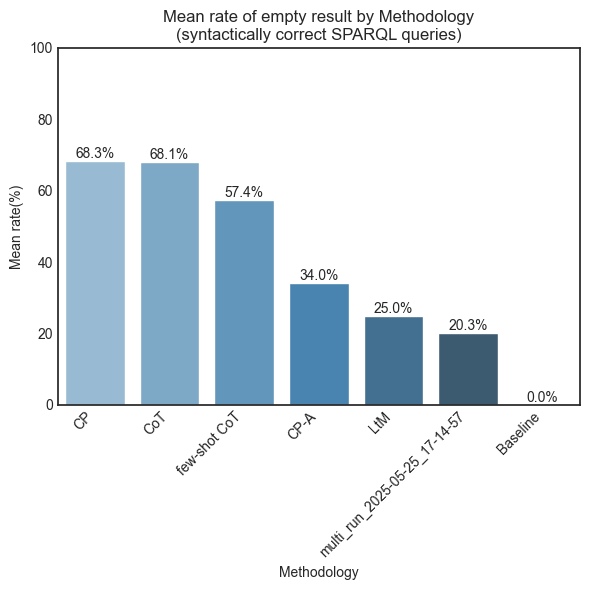

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort by percentage for a clearer plot
summary_sorted = summary.sort_values("percentage_empty_result", ascending=False)

plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x="methodology",
    y="percentage_empty_result",
    data=summary_sorted,
    palette="Blues_d"
)
plt.ylabel('Mean rate(%)')
plt.xlabel('Methodology')
plt.title('Mean rate of empty result by Methodology\n(syntactically correct SPARQL queries)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Optionally annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    # If height is a fraction, multiply by 100
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/empty_result.png", dpi=300, bbox_inches='tight')
plt.show()

### The following plot shows the count of timed-out queries by Methodology (syntactically correct queries only)

In [ ]:
df_error = df[df["is_valid_sparql"] == True]

total_passed_queries_to_endpoint = (
    df_error
    .groupby("methodology")
    .size() 
    .reset_index(name="total_passed_queries_to_endpoint")
)

timeout_counts = (
    df_error[(df_error["error_occured_at_endpoint_message"].str.contains("The read operation timed out")) | 
             (df_error["error_occured_at_endpoint_message"].str.contains("Query timed out after"))]
    .groupby("methodology")
    .size()
    .reset_index(name="timeout_count")
)

timeout_percentages = (
    timeout_counts.merge(total_passed_queries_to_endpoint, on="methodology")
    .assign(timeout_percentage=lambda x: 100 * x.timeout_count / x.total_passed_queries_to_endpoint)
    .sort_values("timeout_percentage")
)

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_45558/1439769522.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


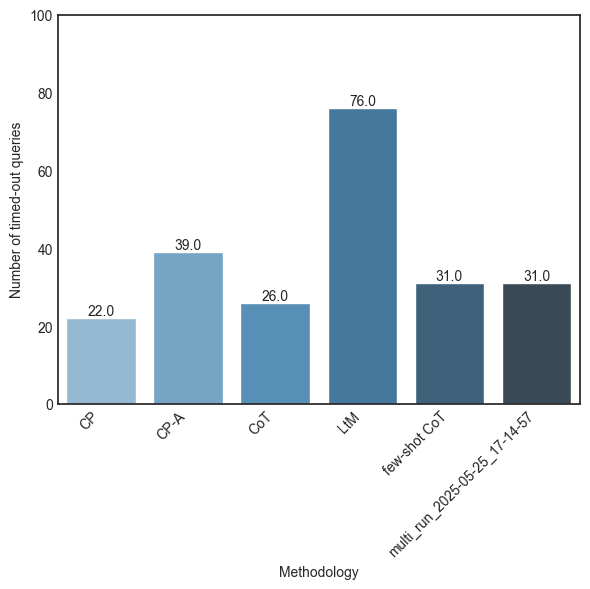

In [ ]:

plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x="methodology",
    y="timeout_count",
    data=timeout_counts,
    palette="Blues_d"
)
plt.ylabel('Number of timed-out queries')
plt.xlabel('Methodology')
#plt.title('Number of timed-out queries by Methodology\n(Syntactically Correct Queries Only)')
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Optionally annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    # If height is a fraction, multiply by 100
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height}',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/timeout_counts.png", dpi=300, bbox_inches='tight')
plt.show()

### Endpoint result distribution for syntactic valid SPARQL queries.

In [ ]:
import pandas as pd
import numpy as np

# 1. Filter for valid SPARQL queries
valid_df = df[df["is_valid_sparql"] == True].copy()

# 2. Classify error messages
valid_df["error_type"] = "Error"  # Default classification

# Apply classifications
empty_result_mask = valid_df["error_occured_at_endpoint_message"] == "no error, but empty result"
timeout_mask = valid_df["error_occured_at_endpoint_message"].str.contains("The read operation timed out", na=False) | valid_df["error_occured_at_endpoint_message"].str.contains("Query timed out after", na=False)
no_error_mask = valid_df["error_occured_at_endpoint_message"] == "no error"

valid_df.loc[empty_result_mask, "error_type"] = "Empty Result"
valid_df.loc[timeout_mask, "error_type"] = "Timeout"
valid_df.loc[no_error_mask, "error_type"] = "Result"

# 3. Group by experiment and error type to get counts
long_df = valid_df.groupby(["methodology", "error_type"]).size().reset_index(name="count")

# 4. Get total valid queries per experiment
total_per_exp = valid_df.groupby("methodology").size().reset_index(name="total")

# 5. Merge to calculate percentages
long_df = pd.merge(long_df, total_per_exp, on="methodology")
long_df["percentage"] = (long_df["count"] / long_df["total"]) * 100

# 6. Get unique experiments and error types for plotting
experiments = long_df["methodology"].unique()
error_types = long_df["error_type"].unique()

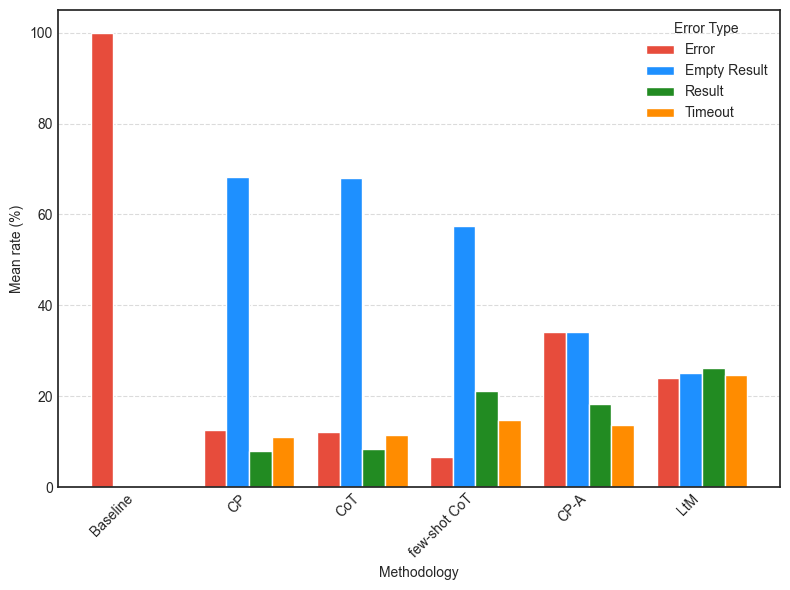

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define your custom order
order = ["Baseline", "CP", "CoT", "few-shot CoT", "CP-A", "LtM"]

long_df = valid_df.groupby(["methodology", "error_type"]).size().reset_index(name="count")
total_per_exp = valid_df.groupby("methodology").size().reset_index(name="total")
long_df = pd.merge(long_df, total_per_exp, on="methodology")
long_df["percentage"] = (long_df["count"] / long_df["total"]) * 100

valid_order = [method for method in order if method in long_df["methodology"].unique()]
experiments = valid_order

error_types = long_df["error_type"].unique()

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.2
index = np.arange(len(experiments))
colors = ['#e74c3c', 'dodgerblue', 'forestgreen', 'darkorange']

for i, error_type in enumerate(error_types):
    error_data = long_df[long_df["error_type"] == error_type]
    error_dict = dict(zip(error_data["methodology"], error_data["percentage"]))
    percentages = [error_dict.get(exp, 0) for exp in experiments]
    bars = ax.bar(index + i*bar_width, percentages, bar_width, label=error_type, color=colors[i % len(colors)])

    # for bar, pct in zip(bars, percentages):
    #     ax.text(
    #         bar.get_x() + bar.get_width() / 2,
    #         bar.get_height(),
    #         f'{pct:.1f}%',
    #         ha='center',
    #         va='bottom',
    #         fontsize=8
    #     )

ax.set_xlabel('Methodology')
ax.set_ylabel('Mean rate (%)')
ax.set_xticks(index + bar_width * (len(error_types) - 1) / 2)
ax.set_xticklabels(experiments, rotation=45, ha='right')
ax.legend(title="Error Type")
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/error_types_percentage.png", dpi=300, bbox_inches='tight')
plt.show()

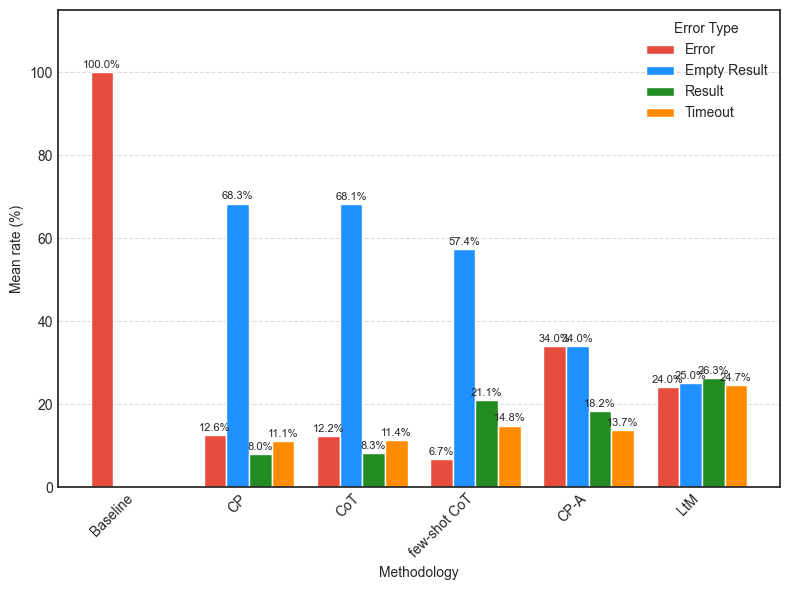

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define your custom order
order = ["Baseline", "CP", "CoT", "few-shot CoT", "CP-A", "LtM"]

long_df = valid_df.groupby(["methodology", "error_type"]).size().reset_index(name="count")
total_per_exp = valid_df.groupby("methodology").size().reset_index(name="total")
long_df = pd.merge(long_df, total_per_exp, on="methodology")
long_df["percentage"] = (long_df["count"] / long_df["total"]) * 100

valid_order = [method for method in order if method in long_df["methodology"].unique()]
experiments = valid_order

error_types = long_df["error_type"].unique()

fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.2
index = np.arange(len(experiments))
colors = ['#e74c3c', 'dodgerblue', 'forestgreen', 'darkorange']

for i, error_type in enumerate(error_types):
    error_data = long_df[long_df["error_type"] == error_type]
    error_dict = dict(zip(error_data["methodology"], error_data["percentage"]))
    percentages = [error_dict.get(exp, 0) for exp in experiments]
    bars = ax.bar(index + i*bar_width, percentages, bar_width, label=error_type, color=colors[i % len(colors)])

    # Add percentage labels on top of each bar
    for bar, pct in zip(bars, percentages):
        if pct > 0:  # Only add text if the percentage is greater than 0
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.5,  # Add a small offset above the bar
                f'{pct:.1f}%',
                ha='center',
                va='bottom',
                fontsize=8,
                rotation=0
            )

ax.set_xlabel('Methodology')
ax.set_ylabel('Mean rate (%)')
ax.set_xticks(index + bar_width * (len(error_types) - 1) / 2)
ax.set_xticklabels(experiments, rotation=45, ha='right')
ax.legend(title="Error Type")
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust the y-axis limit to make room for the percentage labels
y_max = long_df["percentage"].max()
ax.set_ylim(0, y_max * 1.15)  # Add 15% padding above the highest bar

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/error_types_percentage.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
import os
import json
import pandas as pd
from pathlib import Path
from datetime import datetime


def read_metrics_dataset(path):
    with open(path, 'r') as f:
        data = json.load(f)
    if isinstance(data, dict):
        data = [data]
    return data

base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")

methodology_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM",
    "multi_run_2025-05-10_14-26-00": "Baseline",
    "multi_run_2025-05-10_18-05-54": "CP",
    "multi_run_2025-05-11_00-21-16": "CoT",
}

multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

all_metrics_data = []

for multi_run_dir in multi_run_dirs:
    multi_run_name = multi_run_dir.name
    methodology = methodology_mapping.get(multi_run_name, multi_run_name)
    print(f"\nProcessing multi-run: {multi_run_name} (Methodology: {methodology})")
    
    run_dirs = [d for d in multi_run_dir.glob("run_*") if d.is_dir()]
    print(f"Found {len(run_dirs)} run directories")
    
    for run_dir in run_dirs:
        run_name = run_dir.name
        
        eval_dirs = [d for d in run_dir.glob("ev_*") if d.is_dir()]
        
        if not eval_dirs:
            print(f"  × No evaluation directory found in {run_name}")
            continue
            
        for eval_dir in eval_dirs:
            eval_timestamp = eval_dir.name.replace("ev_", "")
            metrics_dataset_file = eval_dir / "metrics_dataset.json"
            
            if not metrics_dataset_file.exists():
                print(f"  × Metrics dataset file not found in {eval_dir.name}")
                continue
                
            print(f"  • Processing {run_name}/{eval_dir.name}")
            
            try:
                metrics_data = read_metrics_dataset(metrics_dataset_file)
                
                for item in metrics_data:
                    item["methodology"] = methodology
                    item["multi_run_dir"] = multi_run_name
                    item["eval_dir"] = eval_dir.name
                    all_metrics_data.append(item)
                    
                print(f"    ✓ Added {len(metrics_data)} items from metrics dataset")
                
            except Exception as e:
                print(f"  × Error processing {metrics_dataset_file}: {e}")

df_metrics = pd.DataFrame(all_metrics_data)
    

Found 7 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-25_17-14-57', 'multi_run_2025-05-02_00-31-21']

Processing multi-run: multi_run_2025-05-11_00-21-16 (Methodology: CoT)
Found 10 run directories
  • Processing run_2/ev_2025-05-18_22-56-33
    ✓ Added 1 items from metrics dataset
  • Processing run_5/ev_2025-05-11_02-25-26
    ✓ Added 1 items from metrics dataset
  • Processing run_4/ev_2025-05-11_01-22-23
    ✓ Added 1 items from metrics dataset
  • Processing run_3/ev_2025-05-11_00-57-28
    ✓ Added 1 items from metrics dataset
  • Processing run_10/ev_2025-05-12_04-07-17
    ✓ Added 1 items from metrics dataset
  • Processing run_6/ev_2025-05-12_02-40-23
    ✓ Added 1 items from metrics dataset
  • Processing run_1/ev_2025-05-12_00-25-08
    ✓ Added 1 items from metrics dataset
  • Processing run_8/ev_2025-05-11_09-54-17


In [ ]:
metrics_avg = df_metrics.groupby('methodology').agg({
    'SP-BLEU': 'mean',
    'METEOR': 'mean',
    'avg_result_excluding_empty_result_precision': 'mean',
    'avg_result_excluding_empty_result_recall': 'mean',
    'avg_result_excluding_empty_result_f1': 'mean'
}).reset_index()

In [ ]:
metrics_avg.head()

,methodology,SP-BLEU,METEOR,avg_result_excluding_empty_result_precision,avg_result_excluding_empty_result_recall,avg_result_excluding_empty_result_f1
0,Baseline,0.016570,0.193967,0.000000,0.000000,0.000000
1,CP,0.037726,0.292094,0.000000,0.000000,0.000000
2,CP-A,0.188117,0.483798,0.485643,0.503907,0.484273
3,CoT,0.064393,0.316409,0.026363,0.032888,0.028580
4,LtM,0.197031,0.443884,0.488975,0.599904,0.510755


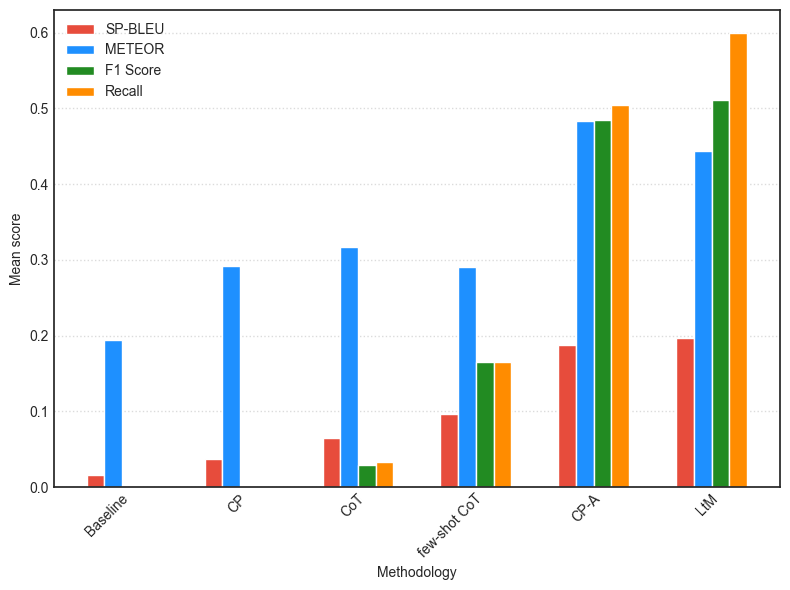

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define your custom order
order = ["Baseline", "CP", "CoT", "few-shot CoT", "CP-A", "LtM"]

# Filter to methodologies that exist in your data
valid_order = [method for method in order if method in metrics_avg['methodology'].values]

# Convert to categorical type to ensure proper ordering
metrics_avg['methodology'] = pd.Categorical(metrics_avg['methodology'], categories=valid_order, ordered=True)
metrics_avg = metrics_avg.sort_values('methodology')

# Define metrics to plot
metrics = [
    'SP-BLEU', 
    'METEOR', 
    'avg_result_excluding_empty_result_f1',
    'avg_result_excluding_empty_result_recall', 
    'avg_result_excluding_empty_result_precision'
]

# Define nicer labels for the legend
metric_labels = [
    'SP-BLEU', 
    'METEOR', 
    'F1 Score', 
    'Recall', 
    'Precision'
]

# Setup figure
fig, ax = plt.subplots(figsize=(8, 6))

# Set width of bars
bar_width = 0.15
index = np.arange(len(valid_order))
colors = ['#e74c3c', 'dodgerblue', 'forestgreen', 'darkorange']

# Create bars for each metric
for i, (metric, label, color) in enumerate(zip(metrics, metric_labels, colors)):
    values = [metrics_avg[metrics_avg['methodology'] == exp][metric].values[0] for exp in valid_order]
    ax.bar(index + i*bar_width - bar_width*2, values, bar_width, label=label, color=color)
    
    # # Add value labels on top of each bar
    # for j, value in enumerate(values):
    #     ax.text(index[j] + i*bar_width - bar_width*2, value, f'{value:.2f}', 
    #             ha='center', va='bottom', fontsize=8)

# Labels and legend
ax.set_xlabel('Methodology')
ax.set_ylabel('Mean score')
ax.set_xticks(index)
ax.set_xticklabels(valid_order, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle=':', linewidth=1, alpha=0.7)

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/combined_avg_metrics_bars_excluding_empty_result.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#Table for mean f1, precision and recall, excluding empty results


# Create a table with the selected metrics
table_df = metrics_avg[['methodology'] + metrics].copy()

# Rename columns for the table
rename_dict = dict(zip(metrics, metric_labels))
rename_dict['avg_result_excluding_empty_result_f1'] = 'F1 Score'
rename_dict['avg_result_excluding_empty_result_recall'] = 'Recall'
rename_dict['avg_result_excluding_empty_result_precision'] = 'Precision'
table_df = table_df.rename(columns=rename_dict)

# Format numbers to 2 decimal places
for col in metric_labels:
    table_df[col] = table_df[col].map(lambda x: f'{x:.2f}')

# Create LaTeX table
latex_table = table_df.to_latex(index=False, escape=False)

# Make the table look better for LaTeX
latex_table = latex_table.replace('tabular}{lrrrrr}', 'tabular}{l|rrrrr}')
latex_table = latex_table.replace('\\begin{table}', '\\begin{table}[ht]\n\\centering')
latex_table = latex_table.replace('\\end{table}', '\\caption{Performance metrics by methodology}\n\\label{tab:performance_metrics}\n\\end{table}')

# Print LaTeX code that can be copied
print("LaTeX table code:")
print(latex_table)

# Also save to file
with open("./multi_experimental_run_plots/metrics_table.tex", "w") as f:
    f.write(latex_table)


LaTeX table code:
\begin{tabular}{llllll}
\toprule
methodology & SP-BLEU & METEOR & F1 Score & Recall & Precision \\
\midrule
Baseline & 0.02 & 0.19 & 0.00 & 0.00 & 0.00 \\
CP & 0.04 & 0.29 & 0.00 & 0.00 & 0.00 \\
CoT & 0.06 & 0.32 & 0.03 & 0.03 & 0.03 \\
few-shot CoT & 0.10 & 0.29 & 0.16 & 0.16 & 0.16 \\
CP-A & 0.19 & 0.48 & 0.48 & 0.50 & 0.49 \\
LtM & 0.20 & 0.44 & 0.51 & 0.60 & 0.49 \\
NaN & 0.12 & 0.43 & 0.31 & 0.40 & 0.32 \\
\bottomrule
\end{tabular}



### Rate of correct predicted endpoints (target or federated endpoint from ground truth) by methodology.

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_45558/2728882226.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


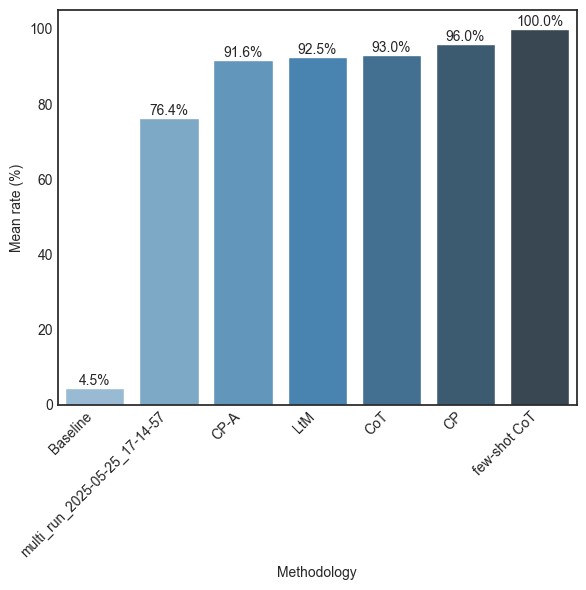

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
target_endpoint_summary = (
    valid_df.groupby("methodology")["predicted_endpoint_or_federated_endpoint"]
        .agg(total="size", n_valid="sum")
        .assign(percentage=lambda x: 100 * x.n_valid / x.total)
        .reset_index()
        .sort_values("percentage", ascending=True)
)

plt.figure(figsize=(6, 6))
ax = sns.barplot(
    x="methodology",
    y="percentage",
    data=target_endpoint_summary,
    palette="Blues_d"
)
plt.ylabel("Mean rate (%)")
plt.xlabel("Methodology")
plt.xticks(rotation=45, ha='right', fontsize=10)

# Annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/percentage_correct_target_or_federated_endpoint.png", dpi=300, bbox_inches='tight')
plt.show()

### Rate of correct predicted target endpoints (target endpoint from ground truth) by methodology.

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_45558/1159339080.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


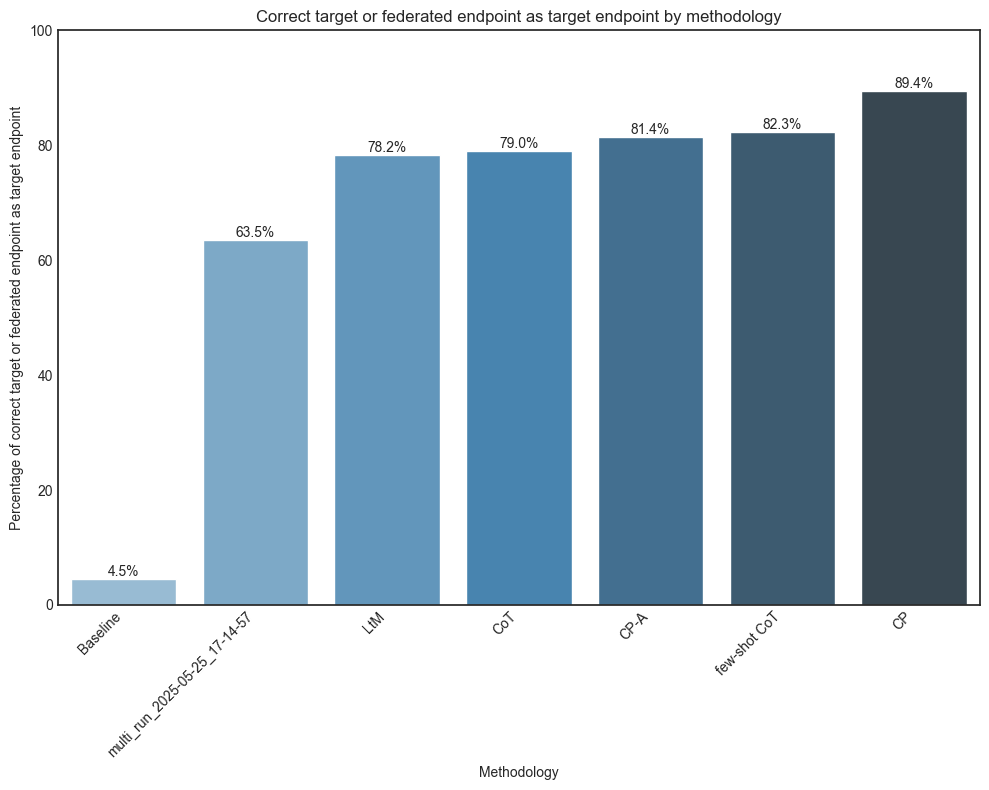

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Summarize percentage of correct predicted endpoints per methodology
target_endpoint_summary = (
    valid_df.groupby("methodology")["predicted_endpoint_equal_to_target_endpoint"]
        .agg(total="size", n_valid="sum")
        .assign(percentage=lambda x: 100 * x.n_valid / x.total)
        .reset_index()
        .sort_values("percentage", ascending=True)
)

plt.figure(figsize=(10, 8))
ax = sns.barplot(
    x="methodology",
    y="percentage",
    data=target_endpoint_summary,
    palette="Blues_d"
)

plt.ylabel('Percentage of correct target or federated endpoint as target endpoint')
plt.xlabel('Methodology')
plt.title('Correct target or federated endpoint as target endpoint by methodology')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.ylim(0, 100)

# Annotate bars with the percentage
for p in ax.patches:
    height = p.get_height()
    plt.text(
        p.get_x() + p.get_width() / 2,
        height,
        f'{height:.1f}%',
        ha='center',
        va='bottom'
    )

plt.tight_layout()
#plt.savefig("./plots_multi_run/percentage_correct_target_or_federated_endpoint.png", dpi=300, bbox_inches='tight')
plt.show()

## The following section evaluates the total token usage, distribution of prompt and completion tokens, and the variance of the token usage for each methodology.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_token = df.copy()


ltm_mask = df_token['methodology'] == 'LtM'
df_token.loc[ltm_mask, 'sparql_query_construction_total_tokens'] = (
    df_token.loc[ltm_mask, ['planning_total_tokens', 'pattern_total_tokens', 'assembler_total_tokens']]
    .sum(axis=1)

)

# Filter out any rows where we don't have token data
df_token = df_token.dropna(subset=['sparql_query_construction_total_tokens'])

### The following plots shows the variance of the total token usage by methodology.

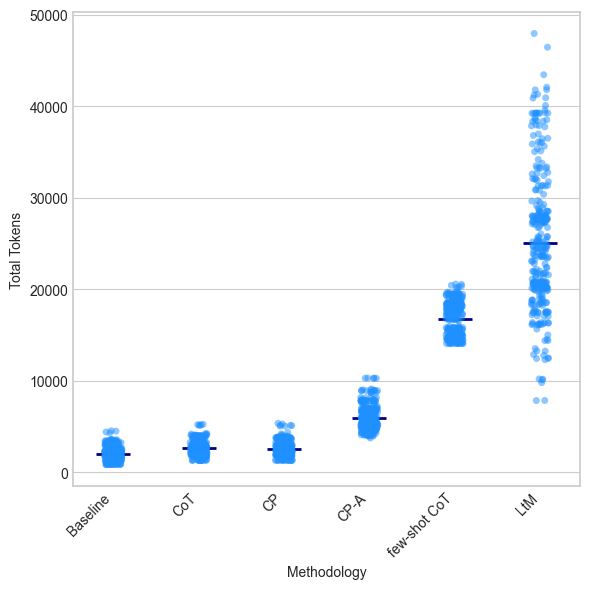

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size and style
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")

# Create the stripplot for individual data points
ax = sns.stripplot(
    data=df_token,
    x='methodology',
    y='sparql_query_construction_total_tokens',
    order=["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"],
    alpha=0.5,
    size=5,
    jitter=True,
    color='dodgerblue',
    edgecolor='none',
)

# Calculate means for each methodology
means = df_token.groupby('methodology')['sparql_query_construction_total_tokens'].mean()

# Add horizontal lines for the means
for i, method in enumerate(["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]):
    if method in means:
        mean_val = means[method]
        plt.hlines(y=mean_val, xmin=i-0.2, xmax=i+0.2, colors='navy', linewidth=2)

plt.xlabel('Methodology')
plt.ylabel('Total Tokens')
plt.xticks(rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/token_usage_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/cf/q7bl9m0529ncggwfh1ml6k5m0000gn/T/ipykernel_45558/695548835.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(


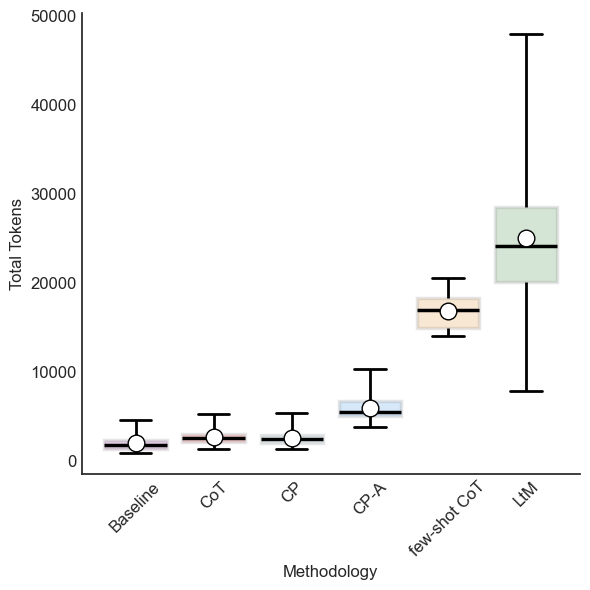

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the figure
plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(6, 6))

# Define color palette for all methodologies
plot_palette = {
    "Baseline": "purple",
    "CoT": "red",
    "CP": "skyblue",
    "CP-A": "dodgerblue",
    "few-shot CoT": "darkorange",
    "LtM": "forestgreen"
}

methodology_order = ["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]

bp = sns.boxplot(
    x="methodology", 
    y="sparql_query_construction_total_tokens", 
    data=df_token, 
    ax=ax,
    order=methodology_order,
    palette=plot_palette,
    medianprops={"color": "black", "linewidth": 2.5},
    whiskerprops={"color": "black", "linewidth": 2},
    capprops={"color": "black", "linewidth": 2},
    boxprops={"alpha": 0.2, "edgecolor": "gray", "linewidth": 2.5},
    showfliers=False,
    whis=[0, 100]
)

for method_idx, method_name in enumerate(methodology_order):
    method_data = df_token[df_token["methodology"] == method_name]
    if not method_data.empty:
        mean_value = method_data["sparql_query_construction_total_tokens"].mean()
        ax.plot(method_idx, mean_value, 'o',
                markerfacecolor='white',
                markeredgecolor='black',
                markersize=12,
                markeredgewidth=1,
                zorder=3)

ax.set_xlabel("Methodology", fontsize=12)
ax.set_ylabel("Total Tokens", fontsize=12)
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

### The following plots show the mean distribution of prompt and completion tokens for each methodology.

In [ ]:
# This code block is used to calculate the mean distribution of tokens for each methodology


# Start with a copy of the original dataframe
df_tokens = df.copy()

# For standard methodologies, filter out rows with NaN values
std_data = df_tokens[df_tokens['methodology'] != 'LtM'].dropna(
    subset=['sparql_query_construction_prompt_tokens', 'sparql_query_construction_completion_tokens']
)

# For LtM methodology, filter out rows with NaN in component columns
ltm_data = df_tokens[df_tokens['methodology'] == 'LtM'].dropna(
    subset=[
        'planning_prompt_tokens', 'planning_completion_tokens',
        'pattern_prompt_tokens', 'pattern_completion_tokens',
        'assembler_prompt_tokens', 'assembler_completion_tokens'
    ]
)

# For LtM, calculate the sum of component tokens
ltm_data['sparql_query_construction_prompt_tokens'] = (
    ltm_data[['planning_prompt_tokens', 'pattern_prompt_tokens', 'assembler_prompt_tokens']]
    .sum(axis=1)
)

ltm_data['sparql_query_construction_completion_tokens'] = (
    ltm_data[['planning_completion_tokens', 'pattern_completion_tokens', 'assembler_completion_tokens']]
    .sum(axis=1)
)

# Combine the filtered dataframes
df_tokens_clean = pd.concat([std_data, ltm_data])

# Calculate mean values for each methodology
token_means = df_tokens_clean.groupby('methodology').agg({
    'sparql_query_construction_prompt_tokens': 'mean',
    'sparql_query_construction_completion_tokens': 'mean'
}).reset_index()

Token usage by methodology:
    methodology  sparql_query_construction_prompt_tokens  \
0      Baseline                              1849.949367   
1           CoT                              2333.010417   
2            CP                              2347.884375   
3          CP-A                              5766.643750   
4  few-shot CoT                             15968.134752   
5           LtM                             24301.404389   

   sparql_query_construction_completion_tokens  total_tokens  
0                                   120.465190   1970.414557  
1                                   319.104167   2652.114583  
2                                   243.915625   2591.800000  
3                                   167.271875   5933.915625  
4                                   820.184397  16788.319149  
5                                   709.583072  25010.987461  


<Figure size 800x600 with 0 Axes>

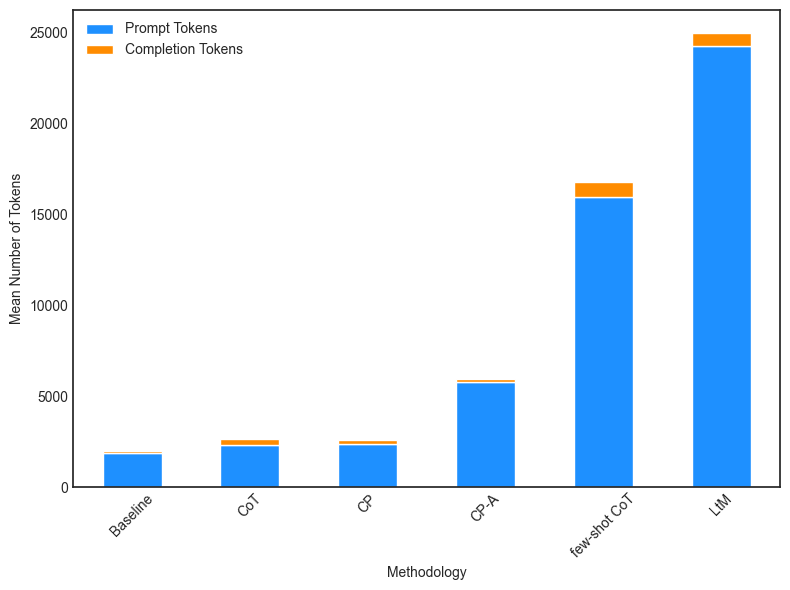

In [ ]:
# Create the plot
plt.figure(figsize=(8, 6))
methodology_order = ["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]
token_means = token_means.set_index('methodology').reindex(methodology_order).reset_index()

# Add a column for total tokens
token_means['total_tokens'] = token_means['sparql_query_construction_prompt_tokens'] + token_means['sparql_query_construction_completion_tokens']

# Print the token counts for verification
print("Token usage by methodology:")
print(token_means[['methodology', 'sparql_query_construction_prompt_tokens', 
                  'sparql_query_construction_completion_tokens', 'total_tokens']])

# Create a stacked bar chart
ax = token_means.plot(
    x='methodology',
    y=['sparql_query_construction_prompt_tokens', 'sparql_query_construction_completion_tokens'],
    kind='bar',
    stacked=True,
    color=['dodgerblue', 'darkorange'],
    figsize=(8, 6)
)


#plt.title('Average Token Usage by Methodology', fontsize=14)
plt.xlabel('Methodology')
plt.ylabel('Mean Number of Tokens')
plt.legend(['Prompt Tokens', 'Completion Tokens'])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/prompt_completion_token_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

### Average token usage ratio by methodology, accompagnied by F1 score.

Token usage by methodology:
    methodology  sparql_query_construction_prompt_tokens  \
0      Baseline                              1849.949367   
1           CoT                              2333.010417   
2            CP                              2347.884375   
3          CP-A                              5766.643750   
4  few-shot CoT                             15968.134752   
5           LtM                             24301.404389   

   sparql_query_construction_completion_tokens  total_tokens  
0                                   120.465190   1970.414557  
1                                   319.104167   2652.114583  
2                                   243.915625   2591.800000  
3                                   167.271875   5933.915625  
4                                   820.184397  16788.319149  
5                                   709.583072  25010.987461  

F1 scores by methodology:
    methodology  avg_result_excluding_empty_result_f1
0      Baseline              

<Figure size 1200x700 with 0 Axes>

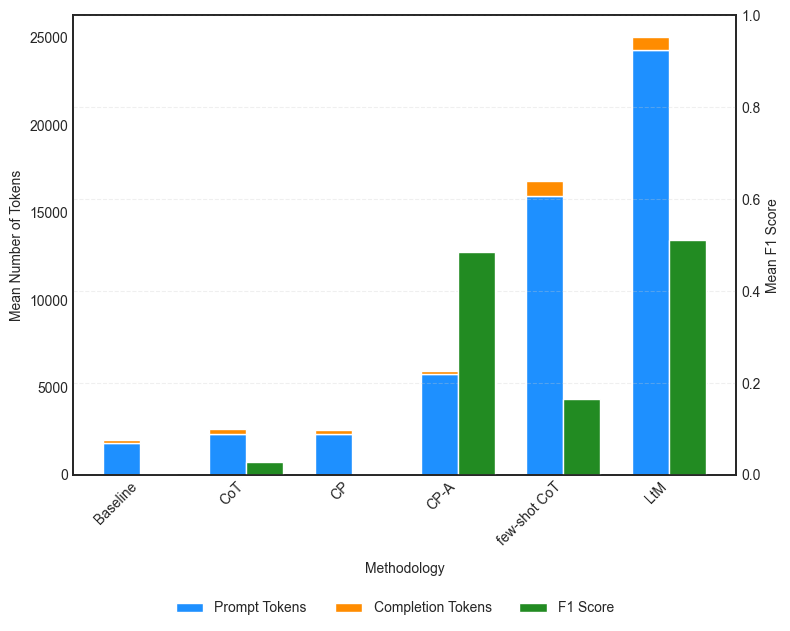

In [ ]:
# Create the plot
plt.figure(figsize=(12, 7))  # Increased height to accommodate legend
methodology_order = ["Baseline", "CoT", "CP", "CP-A", "few-shot CoT", "LtM"]

# Ensure both dataframes have the same methodology order
token_means = token_means.set_index('methodology').reindex(methodology_order).reset_index()
metrics_avg = metrics_avg.set_index('methodology').reindex(methodology_order).reset_index()

# Add a column for total tokens
token_means['total_tokens'] = token_means['sparql_query_construction_prompt_tokens'] + token_means['sparql_query_construction_completion_tokens']

# Print the token counts and F1 scores for verification
print("Token usage by methodology:")
print(token_means[['methodology', 'sparql_query_construction_prompt_tokens', 
                  'sparql_query_construction_completion_tokens', 'total_tokens']])
print("\nF1 scores by methodology:")
print(metrics_avg[['methodology', 'avg_result_excluding_empty_result_f1']])

# Set width of bars and positions
bar_width = 0.35
index = np.arange(len(methodology_order))

# Create figure with two y-axes
fig, ax1 = plt.subplots(figsize=(8, 6))  # Increased height
ax2 = ax1.twinx()

# Plot token usage as stacked bars on the left axis
p1 = ax1.bar(index - bar_width/2, 
             token_means['sparql_query_construction_prompt_tokens'], 
             bar_width, 
             color='dodgerblue', 
             label='Prompt Tokens')
             
p2 = ax1.bar(index - bar_width/2, 
             token_means['sparql_query_construction_completion_tokens'], 
             bar_width, 
             bottom=token_means['sparql_query_construction_prompt_tokens'],
             color='darkorange', 
             label='Completion Tokens')

# Plot F1 scores as bars on the right axis
p3 = ax2.bar(index + bar_width/2, 
             metrics_avg['avg_result_excluding_empty_result_f1'], 
             bar_width, 
             color='forestgreen', 
             label='F1 Score')

# Set labels and ticks
ax1.set_xlabel('Methodology', labelpad=10) 
ax1.set_ylabel('Mean Number of Tokens')
ax2.set_ylabel('Mean F1 Score')

ax1.set_xticks(index)
ax1.set_xticklabels(methodology_order, rotation=45, ha='right')

# Set y-axis limits for F1 scores (0 to 1)
ax2.set_ylim(0, 1)

# Add grid lines for easier reading
ax2.grid(axis='y', linestyle='--', alpha=0.3)

# Create combined legend
handles = [p1, p2, p3]
labels = ['Prompt Tokens', 'Completion Tokens', 'F1 Score']
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.01), ncol=3)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Increased bottom margin to make room for legend

# Save the figure
plt.savefig("./multi_experimental_run_plots/prompt_completion_token_distribution_f1_comparison.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")


experiment_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM"        
}

multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

all_runs = []

for dir_path in multi_run_dirs:
    json_path = dir_path / "all_runs_data.json"
    
    experiment_name = experiment_mapping.get(dir_path.name, dir_path.name)
    
    if json_path.exists():
        try:
            with open(json_path, 'r') as f:
                runs_data = json.load(f)
                
                for run in runs_data:
                    run["experiment_name"] = experiment_name
                    run["source_dir"] = dir_path.name
                    all_runs.append(run)
                    
            print(f"Loaded {len(runs_data)} runs from {dir_path.name}")
        except Exception as e:
            print(f"Error loading {json_path}: {e}")
    else:
        print(f"File not found: {json_path}")

df = pd.DataFrame(all_runs)

print(f"Total runs loaded: {len(df)}")
print(f"Experiments: {df['experiment_name'].unique()}")
print(f"Available metrics: {df.columns.tolist()}")


Found 7 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-25_17-14-57', 'multi_run_2025-05-02_00-31-21']
Loaded 10 runs from multi_run_2025-05-11_00-21-16
Loaded 10 runs from multi_run_2025-05-04_00-51-30
Loaded 10 runs from multi_run_2025-05-10_18-05-54
Loaded 10 runs from multi_run_2025-05-06_22-14-46
Loaded 10 runs from multi_run_2025-05-10_14-26-00
File not found: /Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official/multi_run_2025-05-25_17-14-57/all_runs_data.json
Loaded 10 runs from multi_run_2025-05-02_00-31-21
Total runs loaded: 60
Experiments: ['multi_run_2025-05-11_00-21-16' 'few-shot CoT'
 'multi_run_2025-05-10_18-05-54' 'LtM' 'multi_run_2025-05-10_14-26-00'
 'CP-A']
Available metrics: ['SP-BLEU', 'METEOR', 'num_none_queries', 'size_of_test_set', 'error_at_endpoint

In [ ]:
df[df["experiment_name"]=="LtM"]

,SP-BLEU,METEOR,num_none_queries,size_of_test_set,error_at_endpoints,empty_results_count,syntactically_valid_queries_count,avg_result_including_empty_result_precision,avg_result_including_empty_result_recall,avg_result_including_empty_result_f1,...,avg_result_excluding_empty_result_f1,number_of_query_results_evaluated_excluding_empty_result,list_evaluated_queries_excluding_empty_result,avg_result_all_precision,avg_result_all_recall,avg_result_all_f1,number_of_query_results_evaluated_all,list_evaluated_queries_all,experiment_name,source_dir
30,0.210627,0.461113,0,32,10,7,30,0.257637,0.392780,0.282044,...,0.433915,13,"[SwissLipids/5.ttl, UniProt/51_all_proteins_li...",0.161023,0.245488,0.176278,32,[],LtM,multi_run_2025-05-06_22-14-46
31,0.198602,0.441190,0,32,11,9,30,0.138755,0.173092,0.150419,...,0.285796,10,[UniProt/51_all_proteins_linked_to_arachidonat...,0.082386,0.102774,0.089311,32,[],LtM,multi_run_2025-05-06_22-14-46
32,0.196357,0.442887,0,31,7,12,31,0.221287,0.335675,0.233163,...,0.487522,11,"[SwissLipids/5.ttl, UniProt/51_all_proteins_li...",0.164181,0.249049,0.172992,31,[],LtM,multi_run_2025-05-06_22-14-46
33,0.182902,0.439839,0,32,16,6,31,0.321345,0.457425,0.353924,...,0.589873,9,"[SwissLipids/5.ttl, UniProt/51_all_proteins_li...",0.150630,0.214418,0.165902,32,[],LtM,multi_run_2025-05-06_22-14-46
34,0.201418,0.442968,0,32,19,6,32,0.266506,0.297334,0.277276,...,0.514940,7,[UniProt/118_biosodafrontend_rat_brain_human_c...,0.108268,0.120792,0.112643,32,[],LtM,multi_run_2025-05-06_22-14-46
35,0.190870,0.440868,0,32,18,7,31,0.240139,0.297334,0.247196,...,0.535592,6,[UniProt/51_all_proteins_linked_to_arachidonat...,0.097556,0.120792,0.100423,32,[],LtM,multi_run_2025-05-06_22-14-46
36,0.194990,0.431903,0,32,17,6,30,0.274876,0.307692,0.286836,...,0.532695,7,"[SwissLipids/5.ttl, UniProt/51_all_proteins_li...",0.111669,0.125000,0.116527,32,[],LtM,multi_run_2025-05-06_22-14-46
37,0.191997,0.444887,0,32,18,8,32,0.229505,0.285714,0.239377,...,0.558547,6,"[SwissLipids/16.ttl, Rhea/94_Select_all_approv...",0.100408,0.125000,0.104728,32,[],LtM,multi_run_2025-05-06_22-14-46
38,0.215346,0.462288,0,32,17,7,31,0.285125,0.283565,0.284336,...,0.568673,7,[UniProt/51_all_proteins_linked_to_arachidonat...,0.124742,0.124060,0.124397,32,[],LtM,multi_run_2025-05-06_22-14-46
39,0.187201,0.430899,0,32,17,9,31,0.214286,0.214286,0.214286,...,0.600000,5,"[SwissLipids/5.ttl, UniProt/45_drugs_targeting...",0.093750,0.093750,0.093750,32,[],LtM,multi_run_2025-05-06_22-14-46


## Mean F1 score distribution of the multi-run experiments by Methodology.

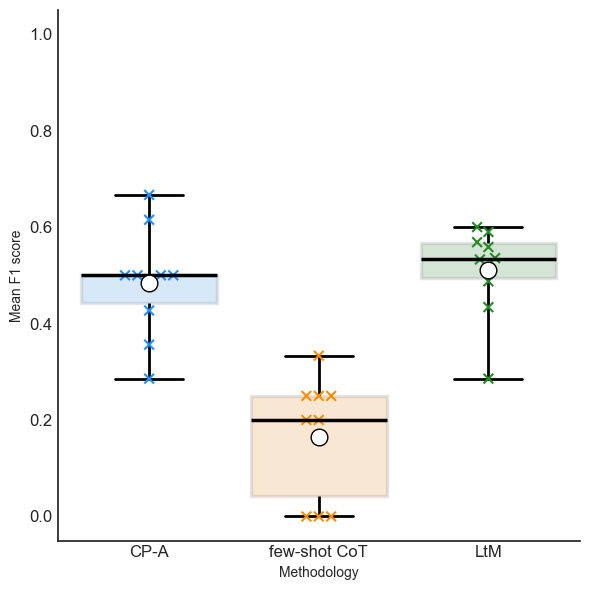

In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

plt.style.use('seaborn-v0_8-white')
fig, ax = plt.subplots(figsize=(6, 6))

plot_palette = {
    "CP-A": "dodgerblue",
    "few-shot CoT": "darkorange",
    "LtM": "forestgreen"
}

experiment_order = ["CP-A", "few-shot CoT", "LtM"]
metric = "avg_result_excluding_empty_result_f1"
#metric = "avg_result_all_f1"
#metric = "avg_result_including_empty_result_f1"


bp = sns.boxplot(x="experiment_name", y=metric, hue="experiment_name", data=df, ax=ax,
            order=experiment_order,
            hue_order=experiment_order,
            palette=plot_palette,  # Use the same palette as for crosses
            medianprops={"color": "black", "linewidth": 2.5},
            whiskerprops={"color": "black", "linewidth": 2},
            capprops={"color": "black", "linewidth": 2},
            boxprops={"alpha": 0.2, "edgecolor": "gray", "linewidth": 2.5},
            showfliers=False,
            whis=[0, 100],
            legend=False)


sns.swarmplot(x="experiment_name", y=metric, hue="experiment_name", data=df, ax=ax,
              order=experiment_order,
              hue_order=experiment_order,
              palette=plot_palette,
              size=7,
              marker='x',
              linewidth=1.5,
              zorder=2,
              legend=False)

for experiment_idx, experiment_name_val in enumerate(experiment_order):
    experiment_data = df[df["experiment_name"] == experiment_name_val]
    if not experiment_data.empty:
        mean_value = experiment_data[metric].mean()
        ax.plot(experiment_idx, mean_value, 'o',
                markerfacecolor='white',
                markeredgecolor='black',
                markersize=12,
                markeredgewidth=1,
                zorder=3)

ax.set_xlabel("Methodology")
ax.set_ylabel("Mean F1 score")
#ax.set_title("Methodology F1 scores\n", fontsize=16)
#ax.text(0.5, 1.01, "(excluding empty result and query errors)", 
#        transform=ax.transAxes, fontsize=12, ha='center', va='bottom')
ax.set_ylim(-0.05, 1.05)
ax.set_yticks(np.arange(0, 1.1, 0.2))
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
sns.despine(ax=ax)

plt.tight_layout()
plt.savefig("./multi_experimental_run_plots/model_comparison_f1_scores.png", dpi=300, bbox_inches='tight')
plt.show()

summary = df.groupby('experiment_name')[[metric]].agg(['mean', 'std', 'min', 'max'])
if not summary.empty and all(exp in summary.index for exp in experiment_order):
    summary = summary.reindex(experiment_order)

In [ ]:
# Calculate more detailed statistics including quartiles
summary = df.groupby('experiment_name')[metric].agg([
    'mean', 'std', 'min', 
    lambda x: x.quantile(0.25), 
    'median',
    lambda x: x.quantile(0.75),
    'max',
    lambda x: x.quantile(0.75) - x.quantile(0.25)  # IQR
])

# Rename the columns for clarity
summary = summary.rename(columns={
    '<lambda_0>': 'q1',
    '<lambda_1>': 'q3',
    '<lambda_2>': 'iqr'
})

if not summary.empty and all(exp in summary.index for exp in experiment_order):
    summary = summary.reindex(experiment_order)

print(summary)

                     mean       std       min        q1    median        q3  \
experiment_name                                                               
CP-A             0.484273  0.110819  0.285714  0.443240  0.500000  0.500000   
few-shot CoT     0.165000  0.122083  0.000000  0.041667  0.200000  0.250000   
LtM              0.510755  0.093112  0.285796  0.494376  0.534143  0.566141   

                      max       iqr  
experiment_name                      
CP-A             0.666667  0.056760  
few-shot CoT     0.333333  0.208333  
LtM              0.600000  0.071765  


In [ ]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

base_dir = Path("/Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official")

experiment_mapping = {
    "multi_run_2025-05-02_00-31-21": "CP-A",  
    "multi_run_2025-05-04_00-51-30": "few-shot CoT",     
    "multi_run_2025-05-06_22-14-46": "LtM"        
}

multi_run_dirs = [d for d in base_dir.glob("multi_run_*") if d.is_dir()]
print(f"Found {len(multi_run_dirs)} multi-run directories: {[d.name for d in multi_run_dirs]}")

stats_data_list = []

for dir_path in multi_run_dirs:
    stats_path = dir_path / "aggregate_statistics.json"
    
    # Get experiment name from mapping
    experiment_name = experiment_mapping.get(dir_path.name, dir_path.name)
    
    if stats_path.exists():
        try:
            with open(stats_path, 'r') as f:
                stats_data = json.load(f)
                stats_data["experiment_name"] = experiment_name
                stats_data["source_dir"] = dir_path.name
                stats_data_list.append(stats_data)
        except Exception as e:
            print(f"Error loading {stats_path}: {e}")
    else:
        print(f"File not found: {stats_path}")

df_aggregated_stats = pd.DataFrame(stats_data_list)

Found 7 multi-run directories: ['multi_run_2025-05-11_00-21-16', 'multi_run_2025-05-04_00-51-30', 'multi_run_2025-05-10_18-05-54', 'multi_run_2025-05-06_22-14-46', 'multi_run_2025-05-10_14-26-00', 'multi_run_2025-05-25_17-14-57', 'multi_run_2025-05-02_00-31-21']
File not found: /Users/sebastian/Documents/Bachelor Thesis/sparql-rag-agent/sparql-rag-agent/experiments/experiments_official/multi_run_2025-05-25_17-14-57/aggregate_statistics.json


In [ ]:
df_aggregated_stats.head()

,avg_result_excluding_empty_result_precision,avg_result_excluding_empty_result_recall,avg_result_excluding_empty_result_f1,avg_result_including_empty_result_precision,avg_result_including_empty_result_recall,avg_result_including_empty_result_f1,avg_result_all_precision,avg_result_all_recall,avg_result_all_f1,experiment_name,source_dir
0,"{'mean': 0.026363370043886558, 'ci_lower': -0....","{'mean': 0.03288755107841244, 'ci_lower': -0.0...","{'mean': 0.02857962445488259, 'ci_lower': -0.0...","{'mean': 0.01387545791783503, 'ci_lower': -0.0...","{'mean': 0.017309237409690755, 'ci_lower': -0....","{'mean': 0.01504190760783294, 'ci_lower': -0.0...","{'mean': 0.00823855313871455, 'ci_lower': -0.0...","{'mean': 0.010277359712003886, 'ci_lower': -0....","{'mean': 0.00893113264215081, 'ci_lower': -0.0...",multi_run_2025-05-11_00-21-16,multi_run_2025-05-11_00-21-16
1,"{'mean': 0.165, 'ci_lower': 0.0776669009099405...","{'mean': 0.165, 'ci_lower': 0.0776669009099405...","{'mean': 0.165, 'ci_lower': 0.0776669009099405...","{'mean': 0.0477328124232149, 'ci_lower': 0.021...","{'mean': 0.0477328124232149, 'ci_lower': 0.021...","{'mean': 0.0477328124232149, 'ci_lower': 0.021...","{'mean': 0.027955665024630538, 'ci_lower': 0.0...","{'mean': 0.027955665024630538, 'ci_lower': 0.0...","{'mean': 0.027955665024630538, 'ci_lower': 0.0...",few-shot CoT,multi_run_2025-05-04_00-51-30
2,"{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...",multi_run_2025-05-10_18-05-54,multi_run_2025-05-10_18-05-54
3,"{'mean': 0.48897501885335204, 'ci_lower': 0.41...","{'mean': 0.5999035897714181, 'ci_lower': 0.517...","{'mean': 0.5107552347414505, 'ci_lower': 0.444...","{'mean': 0.24494600294743346, 'ci_lower': 0.20...","{'mean': 0.30448986882566215, 'ci_lower': 0.24...","{'mean': 0.25688568302047177, 'ci_lower': 0.21...","{'mean': 0.11946130635107814, 'ci_lower': 0.09...","{'mean': 0.15211222543175246, 'ci_lower': 0.10...","{'mean': 0.12569509258541992, 'ci_lower': 0.10...",LtM,multi_run_2025-05-06_22-14-46
4,"{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...","{'mean': 0.0, 'ci_lower': nan, 'ci_upper': nan...",multi_run_2025-05-10_14-26-00,multi_run_2025-05-10_14-26-00


## F1 Score with 95% Confidence Intervals by Methodology.

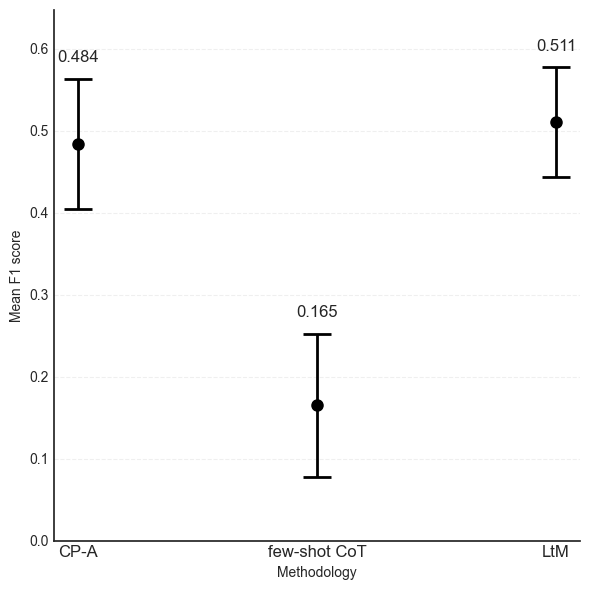

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

experiment_order = ["CP-A", "few-shot CoT", "LtM"]
colors = {
    "CP-A": "dodgerblue",
    "few-shot CoT": "darkorange",
    "LtM": "forestgreen"
}

f1_means = []
errors_minus = []
errors_plus = []

for experiment in experiment_order:
    exp_row = df_aggregated_stats[df_aggregated_stats['experiment_name'] == experiment].iloc[0]
    metric_data = exp_row['avg_result_excluding_empty_result_f1']
    
    mean = metric_data['mean']
    lower = metric_data['ci_lower']
    upper = metric_data['ci_upper']
    
    f1_means.append(mean)
    errors_minus.append(mean - lower)
    errors_plus.append(upper - mean)

fig, ax = plt.subplots(figsize=(6, 6))
x_pos = np.arange(len(experiment_order))

# Create separate errorbar for each experiment with its specific color
for i, exp in enumerate(experiment_order):
    ax.errorbar(x_pos[i], f1_means[i], 
                yerr=[[errors_minus[i]], [errors_plus[i]]],
                fmt='o', 
                markersize=8,
                capsize=10,
                ecolor='black',
                elinewidth=2,
                capthick=2,
                color='black')

for i, mean in enumerate(f1_means):
    ax.text(x_pos[i], mean + errors_plus[i] + 0.02,
             f'{mean:.3f}',
             ha='center', fontsize=12)

ax.set_ylabel('Mean F1 score')
ax.set_xlabel('Methodology')
#ax.set_title("F1 Score with 95% Confidence Intervals\n", fontsize=16)
#ax.text(0.5, 1.01, "(excluding empty result and query errors)", 
#        transform=ax.transAxes, fontsize=12, ha='center', va='bottom')

ax.set_xticks(x_pos)
ax.set_xticklabels(experiment_order, fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_ylim(0, max([mean + err + 0.07 for mean, err in zip(f1_means, errors_plus)]))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('./multi_experimental_run_plots/f1_scores_errorbar.png', dpi=300)
plt.show()